The nv center paper https://pubs.aip.org/avs/aqs/article/2/2/024701/997281/Introduction-to-quantum-optimal-control-for has an example of a control pulse for just the zeeman term of the Hamiltonian.  I want to replicate this and put it in GRAPE to try to understand how to deal with the B-field being aligned or not aligned with the NV-axes.

In [4]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from scipy.constants import physical_constants, h
from dataclasses import dataclass

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
import random

The following cells are to write the Hamiltonian using the rotating wave approximation

In [5]:
#defining constants in hamiltonian
h= 6.582119 * 1e-16 #eV * sec 
Bperpendicular = 10 #mT
Bparallel = 10 #mT
gammanv = 2*np.pi*28 * 1000000 #Hz/mT
omeganv = Bparallel * gammanv
omegamw = 1000000000 #Hz
Delta = omeganv - omegamw
#Delta
Omega = Bperpendicular * gammanv
Omega
uB = physical_constants['Bohr magneton'][0]
g_factor_electron = 2.0028
bvector=[0,0,1]


In [6]:
#h=1

#H0 = ((uB/h) * g_factor_electron) * tensor((sigmax()*bvector[0] + sigmay()*bvector[1] + sigmaz()*bvector[2]))

H0= h*Delta*sigmaz() + Omega*h*sigmax() + Omega*h*sigmay()
H0 = h*Delta*sigmaz()
H0


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 4.99774955e-07  0.00000000e+00]
 [ 0.00000000e+00 -4.99774955e-07]]

In [114]:

H_ops = [gammanv*100*sigmax(),gammanv*100*sigmay()]

#Labels for the graph
H_labels = [r'$u_{x}$',
            r'$u_{y}$',
        ]


In [115]:
#writing out starting state for single qubit

psi0 = basis(2, 0)
print (psi0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]


In [116]:
#creating transform matrix

phi=(np.pi)
#U = 1*rx(phi)
U = ry(phi)
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 6.123234e-17 -1.000000e+00]
 [ 1.000000e+00  6.123234e-17]]

In [117]:
Omega

1759291886.0102842

In [160]:
T = 1/100
steps=100
times = np.linspace(0, T, steps)

In [161]:
##creating initial control pulse values as starting guess for GRAPE

u0 = np.array([np.random.rand(len(times))*T * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]


In [162]:
#doing GRAPE!
R=100
result = cy_grape_unitary(U, H0, H_ops, R, times,u_start=u0, eps=T, phase_sensitive=False,
                          progress_bar=TextProgressBar())   

10.0%. Run time:   3.07s. Est. time left: 00:00:00:27
20.0%. Run time:   6.03s. Est. time left: 00:00:00:24
30.0%. Run time:   9.00s. Est. time left: 00:00:00:21
40.0%. Run time:  11.97s. Est. time left: 00:00:00:17
50.0%. Run time:  14.94s. Est. time left: 00:00:00:14
60.0%. Run time:  17.94s. Est. time left: 00:00:00:11
70.0%. Run time:  20.91s. Est. time left: 00:00:00:08
80.0%. Run time:  23.89s. Est. time left: 00:00:00:05
90.0%. Run time:  26.85s. Est. time left: 00:00:00:02
Total run time:  29.53s


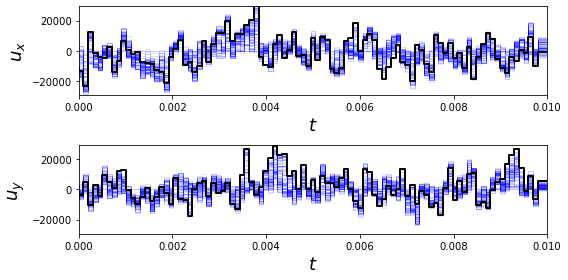

In [163]:
#Plotting pulse sqeuences from GRAPE
plot_grape_control_fields(times, result.u[:,:,:] / (2 * pi), H_labels, uniform_axes=True);

In [164]:
startingstate = Qobj([[1.],
                      [0.]])
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-0.1716693 -0.4587286j  -0.81163993+0.31799399j]
 [ 0.81164683+0.31799005j -0.17166902+0.45874741j]]

In [165]:
finalstate = result.U_f*startingstate
finalstate

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.1716693 -0.4587286j ]
 [ 0.81164683+0.31799005j]]

In [166]:
finalstateideal = U*startingstate
finalstateideal

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

In [167]:
#me_result = mesolve(result.H_t, startingstate, times, c_ops, e_ops,options=Options(nsteps=1e8))

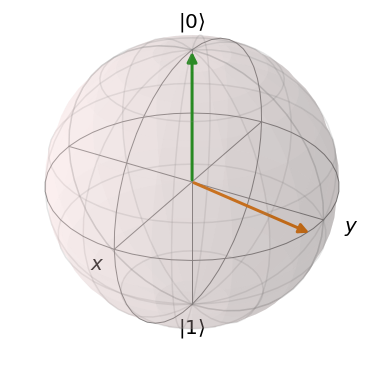

In [168]:
b = Bloch()

#b.add_points(me_result.expect)

b.add_states(startingstate)
b.add_states(finalstate)
b.render()
b.show()